In [108]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.special

%matplotlib inline

## Problem 2

In [39]:
def gauss(x,x0):
    gauss = np.exp(-0.5 * (x - x0)**2 / x0) / (2*np.pi*x0)**0.5
    
    return gauss

def poiss(x,x0):
    poiss = (x0**x) * np.exp(-x0) / scipy.special.factorial(x)
    
    return poiss

def error_func(x0, sig):
    
    """computes the percent error for the Gaussian approximation of a Poisson distribution given 
    a lambda and the number of sigmas at which to compare them.
    
    """
    
    sigma = sig*(x0**0.5)
    x = x0 + sigma
    
    ln_gauss = -0.5 * (((x - x0)**2 / x0) + np.log(2*np.pi*x0)) 
    
    ln_poiss_num = x * np.log(x0) - x0
    ln_poiss_denom = x * np.log(x) - x + np.log(np.sqrt(2*np.pi*x))

    ln_g_p = ln_gauss - ln_poiss_num + ln_poiss_denom
    
    g_p = np.exp(ln_g_p)
    error = 1 - g_p
            
    return error

To be good enough at 3 sigma you need lambda = 8.39
To be good enough at 5 sigma you need lambda = 575.63


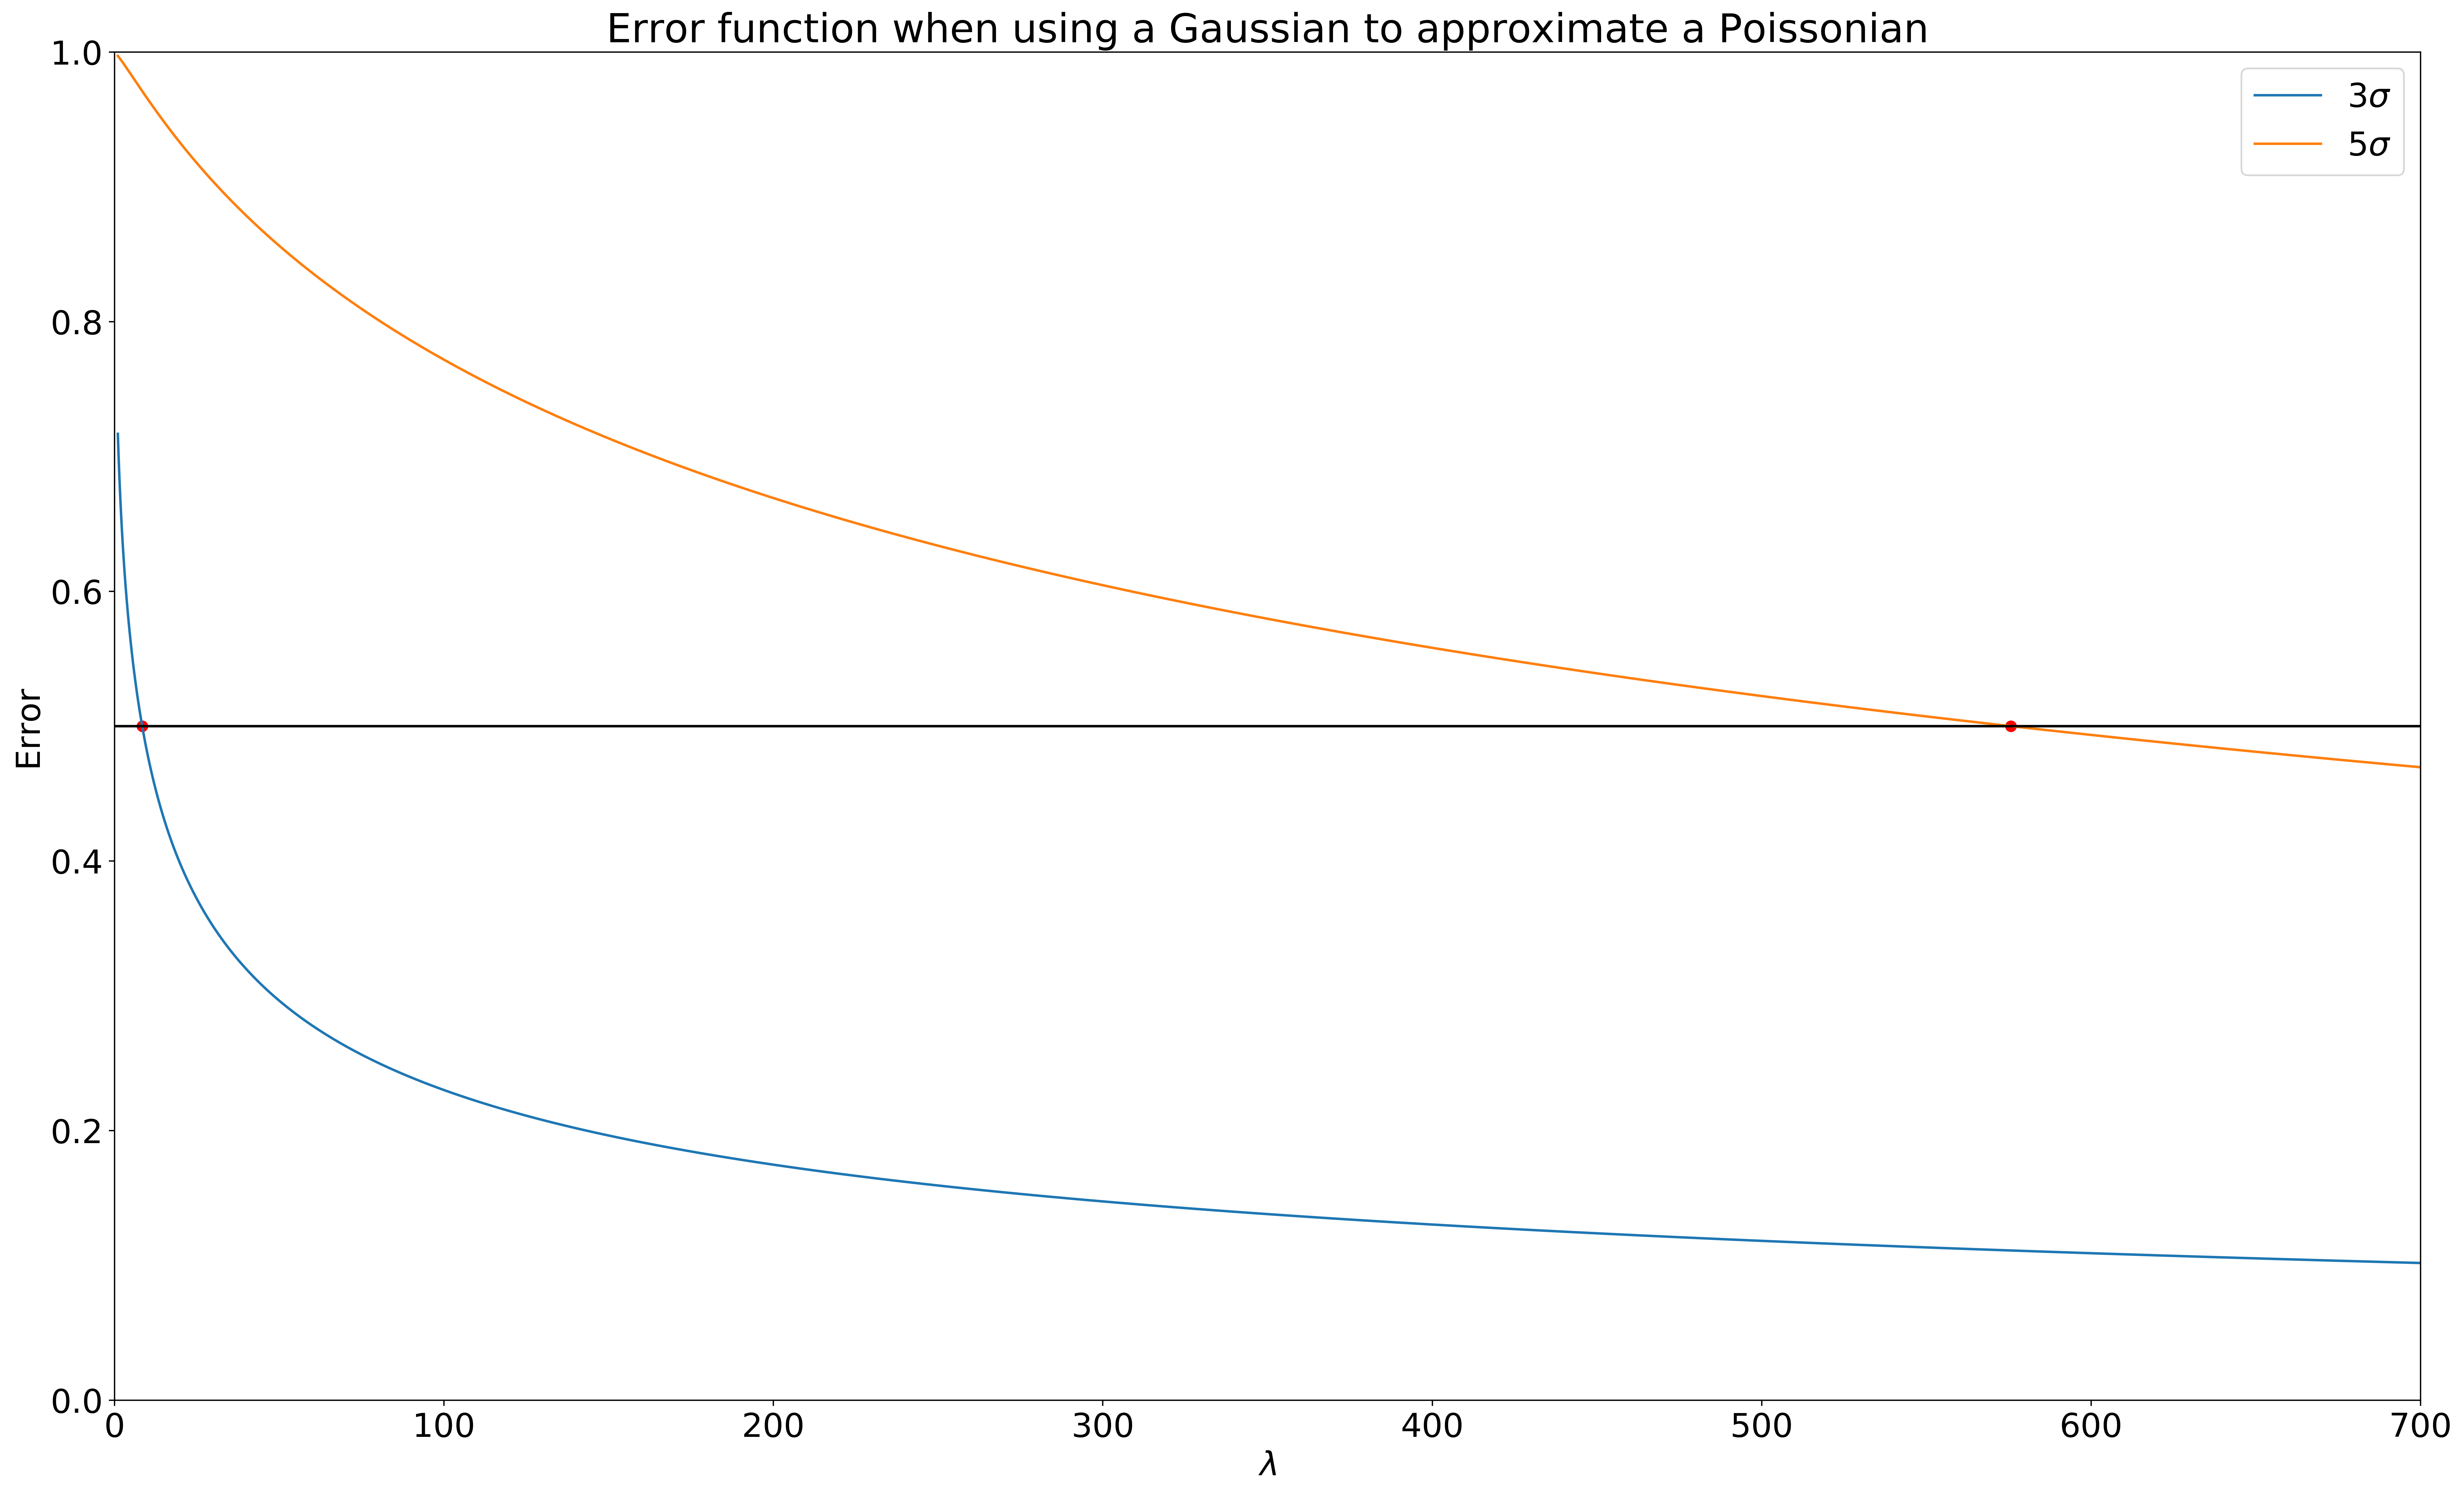

In [117]:
x0 = np.arange(1, 1000, 0.01)

sig3_error = error_func(x0,3)
sig5_error = error_func(x0,5)

sig3_lamb = x0[np.argmin(abs(sig3_error-0.5))]
sig5_lamb = x0[np.argmin(abs(sig5_error-0.5))]

plt.figure(num=1, figsize=(25, 15), dpi=400)
matplotlib.rcParams.update({'font.size': 20})

plt.plot(x0, sig3_error, label = r"3$\sigma$")
plt.plot(x0, sig5_error, label = r"5$\sigma$")

plt.axhline(y = 0.5, color='k')

plt.scatter([sig3_lamb,sig5_lamb],[sig3_error[np.argmin(abs(sig3_error-0.5))],sig5_error[np.argmin(abs(sig5_error-0.5))]],color='r')

plt.legend()

plt.ylim(0,1)
plt.xlim(0,700)

plt.xlabel(r"$\lambda$")
plt.ylabel(r"Error")

plt.title("Error function when using a Gaussian to approximate a Poissonian")

print ("To be good enough at 3 sigma you need lambda = %s" % str(sig3_lamb))
print ("To be good enough at 5 sigma you need lambda = %s" % str(sig5_lamb))

/Users/paulaboubel/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in power


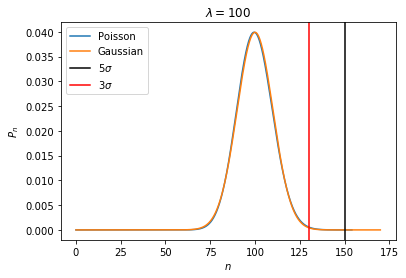

In [41]:
x0 = 100
x = np.arange(0, x0 + 7*x0**0.5, 0.01)

plt.plot(x, poiss(x,x0), label = 'Poisson')
plt.plot(x, gauss(x,x0), label = 'Gaussian')
plt.axvline(x = x0 + 5*x0**0.5, color = 'k', label = r"$5 \sigma$")
plt.axvline(x = x0 + 3*x0**0.5, color = 'r', label = r"$3 \sigma$")

plt.ylabel(r"$P_{n}$")
plt.xlabel(r"$n$")

plt.title(r"$\lambda = %s$" % str(x0))

plt.legend()

## Problem 5

In [54]:
def gaussian_template(x0, sig):
    
    template = np.exp(-0.5*(x-x0)**2/sig**2)
    
    return template
    
def generate_data(amp_true, noise_true):
    
    """Generate a fake data set of a Gaussian with randomly generated noise.
    Parameters
    ----------
    amp_true : scalar
        True amplitude of the Gaussian source.
    noise_true : scalar
        True noise.
    Returns
    -------
    data : np.ndarray
        Generated data array of length 2000.
    """
    
    dx=0.01
    Ninv=1.0/noise_true**2
    x=np.arange(-10,10,dx)
    n=len(x)

    amp_true = 2.0

    template = gaussian_template(x0 = 0,sig = 0.3)
    
    noise = np.random.randn(n)*noise_true
    data = template*amp_true+noise
    
    return data

### Example of one data set

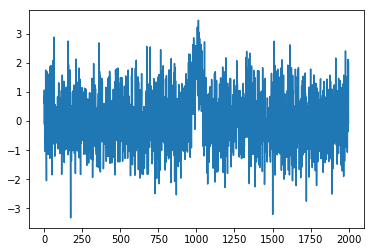

In [115]:
matplotlib.rcParams.update({'font.size': 10})
plt.plot(generate_data(amp_true = 2.0,noise_true = 0.9))

### Next, we generate a bunch of data sets and fit an amplitude and error to each. Each time, we estimate the noise as simply the scatter in the data.

In [82]:
N_chunks = 10000

est_amp = np.zeros(N_chunks)
est_weight = np.zeros(N_chunks)

for chunk in range(N_chunks):
    
    dat = generate_data(amp_true = 2.0,noise_true = 0.9)
    
    noise_est = np.std(dat)
    Ninv_est=1.0/noise_est**2

    snr=np.zeros(n)
    amp=np.zeros(n)
    dat_filt=Ninv_est*dat
    
    template = gaussian_template(x0 = 0,sig = 0.3)
    
    denom=(np.dot(template,Ninv_est*template))

    rhs=np.dot(template,dat_filt)
    amp=rhs/denom
    
    est_amp[chunk] = amp
    est_weight[chunk] = denom

### The estimators are combined using an increasing number of data sets. This is done both by simple averaging and weighted averaging.

In [83]:
weighted = np.zeros(N_chunks)
unweighted = np.zeros(N_chunks)

for i in range(1,N_chunks):
    unweighted[i] = np.average(est_amp[0:i])
    weighted[i] = np.average(est_amp[0:i],weights=est_weight[0:i])

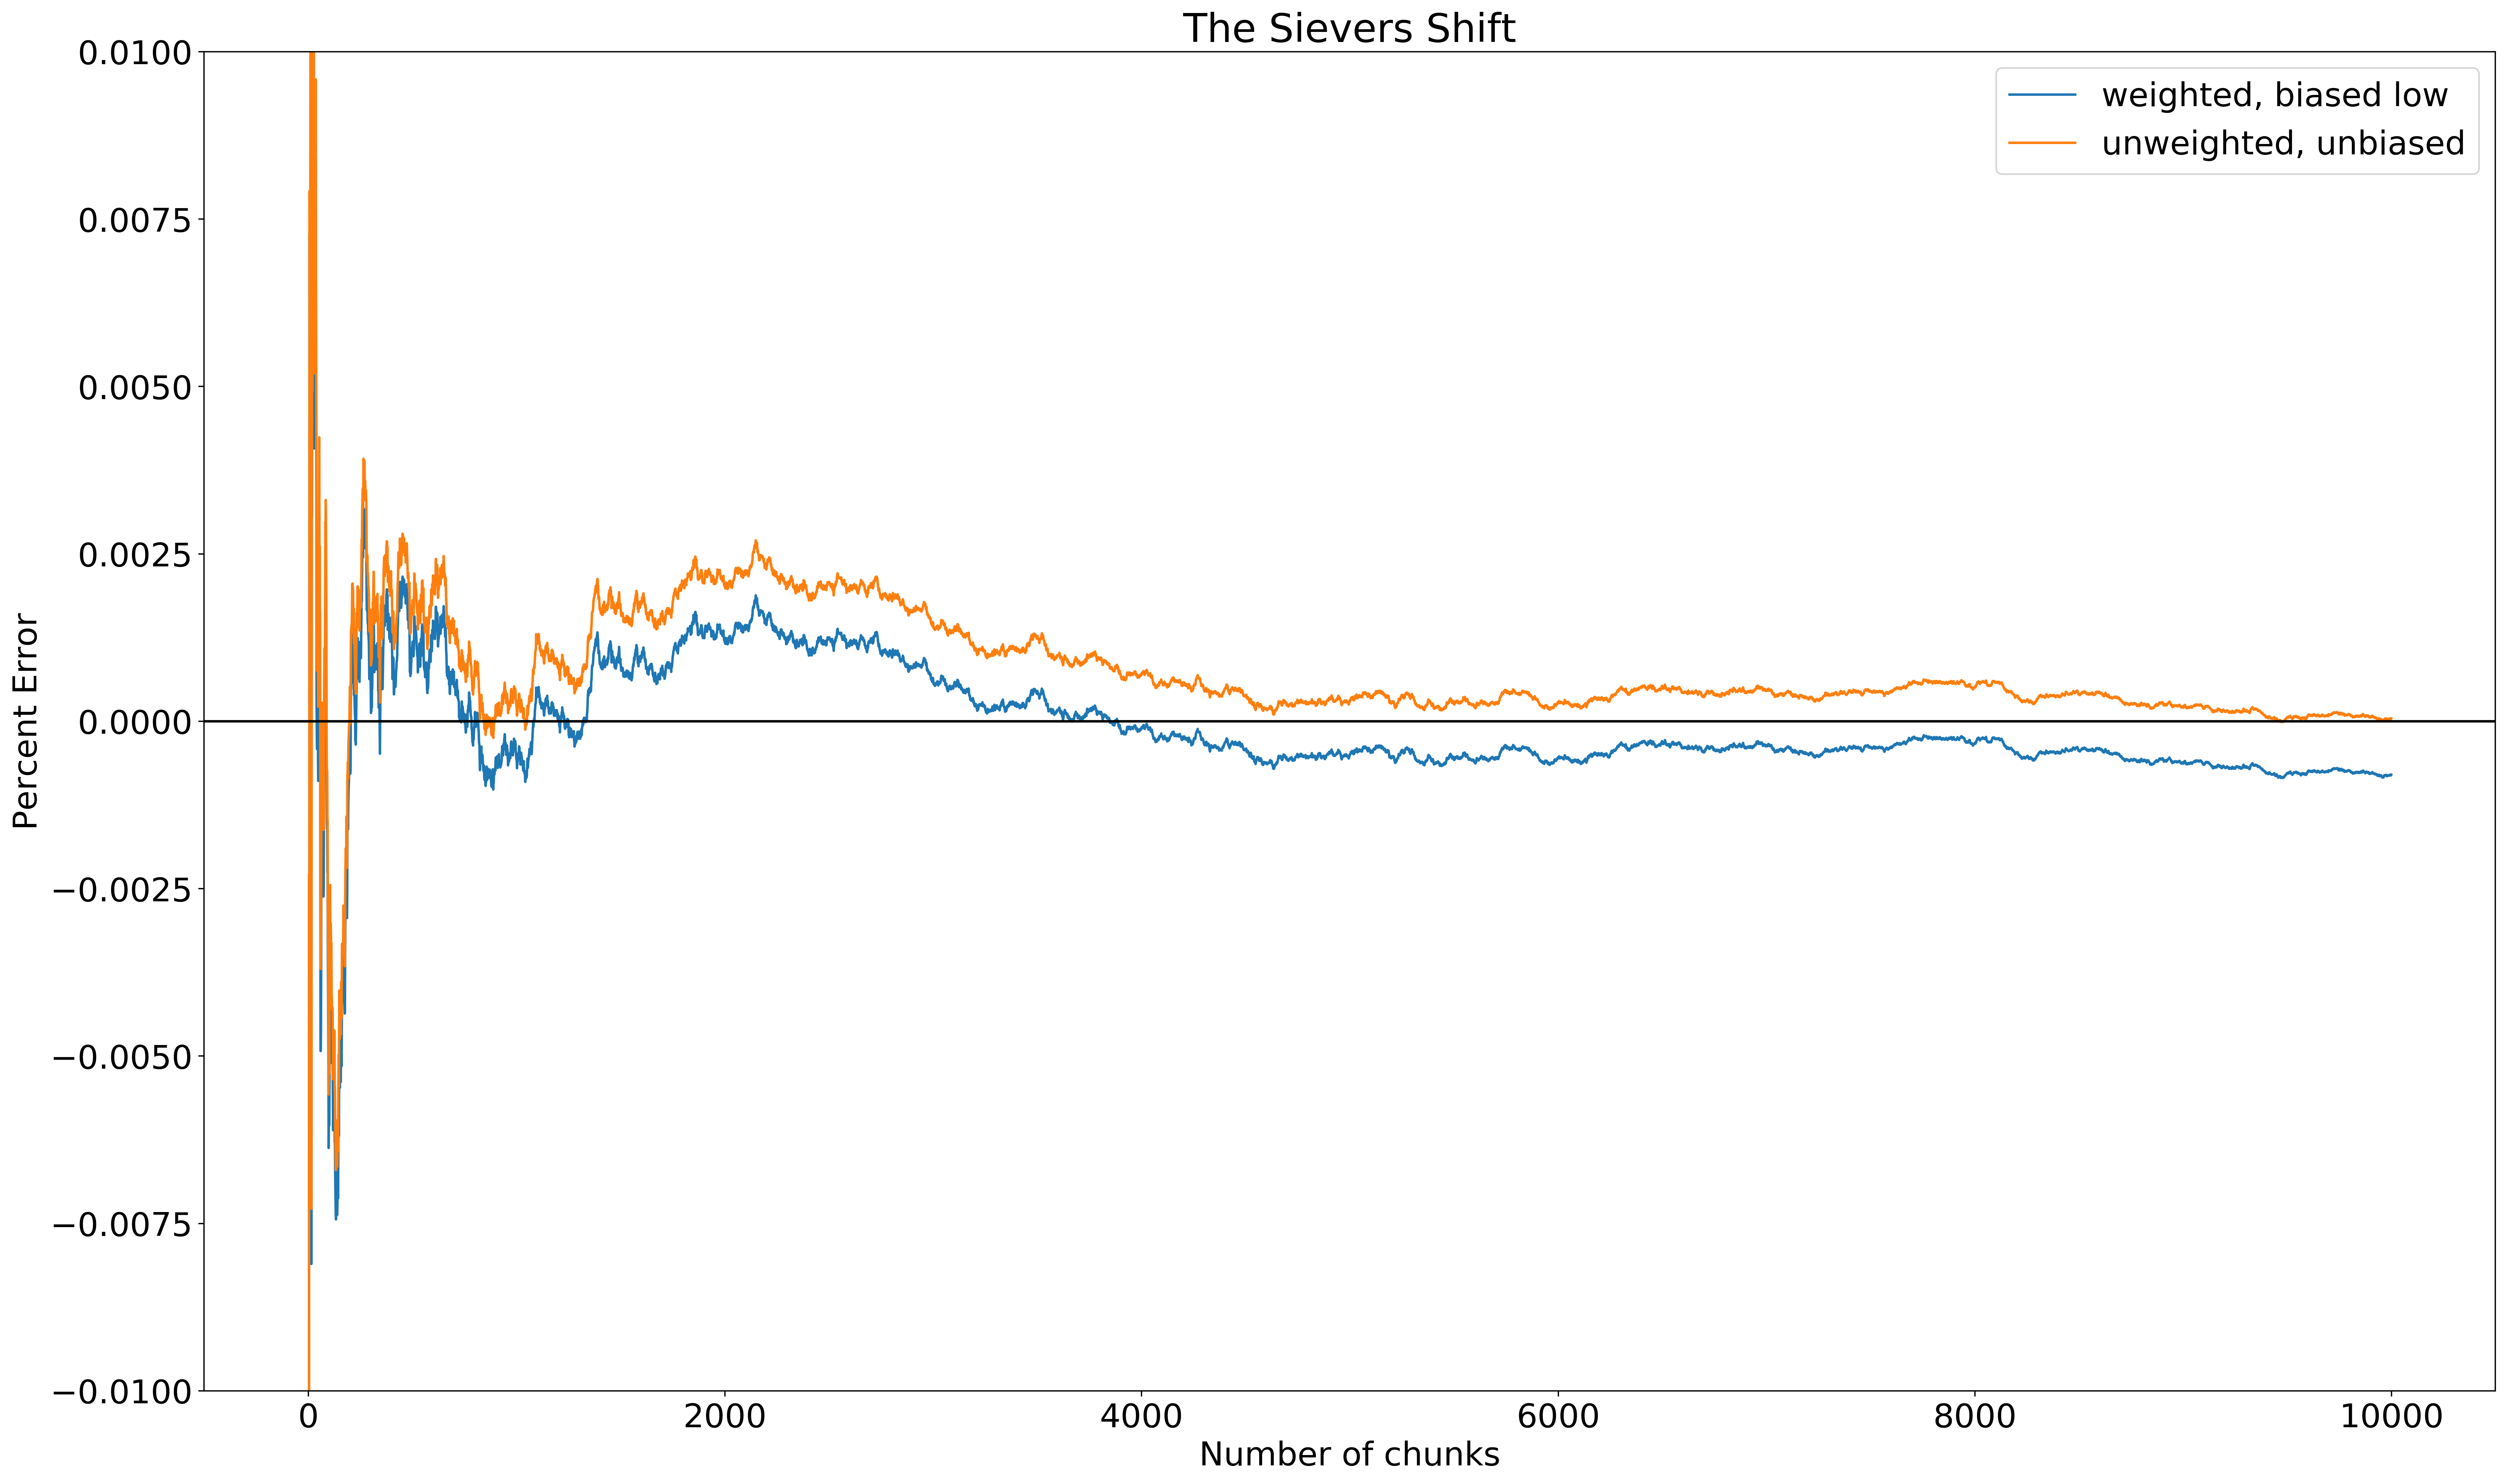

In [109]:
plt.figure(num=1, figsize=(25, 15), dpi=400)
matplotlib.rcParams.update({'font.size': 20})

plt.plot((weighted[1:]-2)/2,label='weighted, biased low')
plt.plot((unweighted[1:]-2)/2,label='unweighted, unbiased')
plt.ylim(-0.01,0.01)
plt.axhline(y=0,color='k')
plt.legend()
plt.title("The Sievers Shift")
plt.xlabel('Number of chunks')
plt.ylabel('Percent Error')

### The above plot shows that as you increase your number of observations, the weighted average of ampltitude estimators tends to be biased low whereas the unweighted average approaches the true amplitude.